In [37]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import albumentations as A
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Leitura dos dados e divisão treino/teste

Antes de começarmos, vale ressaltar que o link fornecido no arquivo PDF prova não contém os rótulos da base. Eles podem ser encontrados [aqui](https://github.com/BotechEngineering/StanfordCarsDatasetCSV/tree/main).

A base Standof Cars já possui seus dados divididos  em conjuntos de treinamento e teste. A divisão é, praticamente, de 50%-50%. Os dados de teste não estão rotulados por classe. Então, usaremos apenas os dados de treinamento em nossos experimentos.

In [38]:
train_labels = pd.read_csv("data/cardatasettrain.csv")
train_labels.drop(columns=[train_labels.columns[0]], inplace=True)
train_labels

,x1,y1,x2,y2,Class,image
0,39,116,569,375,14,00001.jpg
1,36,116,868,587,3,00002.jpg
2,85,109,601,381,91,00003.jpg
3,621,393,1484,1096,134,00004.jpg
4,14,36,133,99,106,00005.jpg
...,...,...,...,...,...,...
8139,3,44,423,336,78,08140.jpg
8140,138,150,706,523,196,08141.jpg
8141,26,246,660,449,163,08142.jpg
8142,78,526,1489,908,112,08143.jpg


Aqui surge nossa primeira dúvida com relação à classe 'indefinida', é apenas uma qualquer, que podemos escolher, ou é o conjunto de todas as outras classes (que não sejam 3, 4, ou 5). Neste notebook, trabalharemos com o caso de 'indefinida' ser uma classe aleatória do conjunto de dados.

In [39]:
np.random.seed(1) # definimos uma seed para conseguirmos reproduzir a escolha

# Escolhemos uma classe aleatóriamente, que no caso é a 41
independent_class = np.random.choice([1,2] + list(range(6, 197)))
print(independent_class)

important_classes = [3,4,5] + [independent_class]

41


Vamos, então separar o conjunto de dados em dois: o conjunto de treinamento, que contém as amostras, de fato, das classes importantes (3, 4, 5 e 41) e o conjunto de pré treinamento, com as amostras das demais classes.

Nossa ideia inicial era fazer um pré treinamento, ou seja, um treinamento inicial apenas com as amostras do conjunto de pré treinamento. Embora esse conjunto não contenha nenhum elemento que desejamos classificar, esse procedimento seria interessante para "acostumar" o modelo a detectar características de imagens de carros, o que poderia ser útil para detectar carros de outras classes.

Acabamos não executando o pré treinamento, pois não houve tempo. Mas, fizemos o preprocessamento desses dados para tal fim.

In [40]:
train_image_root = 'data/cars_train/cars_train/'

In [41]:
pre_train_data = [] # imagens de pré treinamento
train_data = [] # imagens de treinamento
classes1 = [] # classes de pré treinamento
classes2= [] # classes de treinamento

# Divisão dos dados entre os conjuntos de treinamento e pré treinamento
for index, row in train_labels.iterrows():
    img = cv2.imread(f"{train_image_root}{row['image']}", cv2.COLOR_BGR2RGB)
    
    if row['Class'] in important_classes:
        train_data.append(img)
        classes2.append(row['Class'])
    else:
        pre_train_data.append(img)
        classes1.append(row['Class'])

Divisão dos dados de treinamento em conjuntos de treino e teste. 
Vale ressaltar que, para evitar confusão, usaremos o nome treinamento para falar do conjunto (train_data, classes2) e treino para falar do conjunto (x_train, y_train).

In [42]:
x_train, x_test, y_train, y_test = train_test_split(train_data, classes2, test_size=0.3, stratify=classes2, random_state=1)

In [43]:
print("Tamanho do conjunto de pré-treino", len(pre_train_data))
print("Tamanho do conjunto de treinamento", len(x_train))
print("Tamanho do conjunto de teste", len(x_test))

Tamanho do conjunto de pré-treino 7982
Tamanho do conjunto de treinamento 113
Tamanho do conjunto de teste 49


A seguir, vemos a distribuição dos dados no conjunto de treinamento. A distribuição de classes é bastante balanceada.

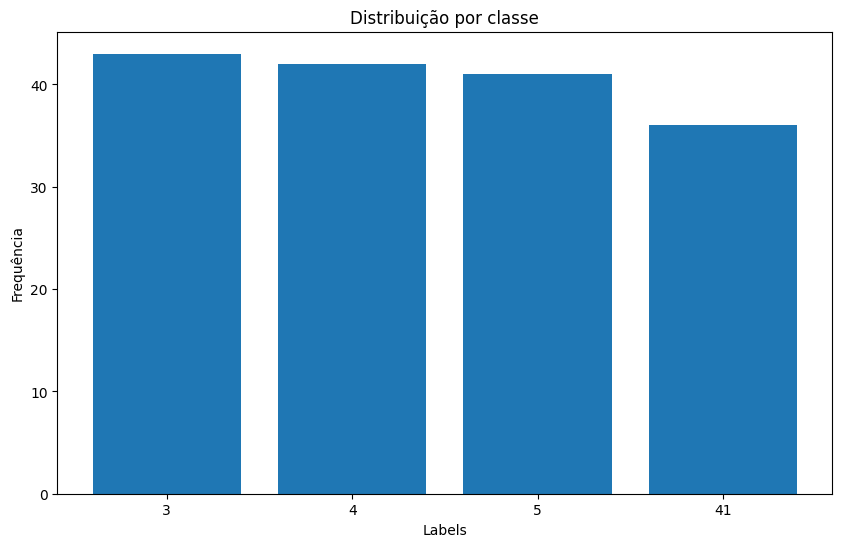

In [44]:
labels, counts = np.unique(np.array(classes2), return_counts=True)
labels = [str(i) for i in labels]

plt.figure(figsize=(10, 6))
plt.bar(labels, counts)
plt.xlabel('Labels')
plt.ylabel('Frequência')
plt.title('Distribuição por classe')
plt.show()

Aqui, vamos definir um processo de data augmentation. Esse processo vai nos ajudar a aumentar a quantidade de amostras das classes não majoritárias, reduzindo o desbalanceamento.

As imagens que vão sofrer aumento vão passar por um processo seguindo o pipeline:
* Rotação horizontal;
* Ajuste do brilho e contraste;
* Redimensionamento aleatório de escala entre 0% e 5%;
* Recorte aleatório de uma região da imagem;
* Redimensionamento para (224, 224), padrão dos modelos do ImageNet;
* Normalização.

In [45]:
def data_augmentation(train, classes, num_augmented=2):
    # ImageNet mean and std for normalization
    imagenet_mean = [0.485, 0.456, 0.406]
    imagenet_std = [0.229, 0.224, 0.225]

    # Define the augmentation and preprocessing pipeline
    transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
        A.RandomScale(scale_limit=(0, 0.05), p=0.5),
        A.RandomResizedCrop(height=224, width=224, scale=(0.8, 1.0), p=0.5),
        A.OpticalDistortion(distort_limit=0.2, shift_limit=0.2, p=0.5),
        A.Resize(224, 224),  # Ensures all images are resized to 224x224
        A.Normalize(mean=imagenet_mean, std=imagenet_std, always_apply=True)  # Normalize to ImageNet stats
    ])

    # Store original and augmented images
    augmented_images = []
    augmented_classes = []

    for img, cls in zip(train, classes):
        # Ensure all images are in 3-channel format
        if len(img.shape) == 2:  # grayscale to RGB
            img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        elif img.shape[2] == 1:  # single channel to RGB
            img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            img_rgb = img  # already in RGB

        # Resize the original image to 224x224
        original_img = cv2.resize(img_rgb, (224, 224))

        # Normalize the original image to ImageNet stats
        original_img = original_img / 255.0  # Scale to [0, 1] range
        original_img = (original_img - imagenet_mean) / imagenet_std

        # Add the original image and class
        augmented_images.append(original_img)
        augmented_classes.append(cls)
        
        # Generate augmented versions
        for _ in range(num_augmented):
            augmented = transform(image=img_rgb)
            augmented_images.append(augmented['image'])
            augmented_classes.append(cls)  # Keep the corresponding class

    # Convert to numpy arrays for consistency
    augmented_images = np.array(augmented_images)
    augmented_classes = np.array(augmented_classes)

    return augmented_images, augmented_classes

Aplicamos o aumento aos conjuntos de treino, perceba que seu tamanho cresceu substancialmente (em 4 vezes).

In [46]:
x_train, y_train = data_augmentation(x_train, y_train, num_augmented=3)

In [47]:
print("Tamanho do conjunto de pré-treino", len(pre_train_data))
print("Tamanho do conjunto de treinamento", len(x_train))
print("Tamanho do conjunto de teste", len(x_test))

Tamanho do conjunto de pré-treino 7982
Tamanho do conjunto de treinamento 452
Tamanho do conjunto de teste 49


# Treino

In [48]:
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn import metrics
from tensorflow.keras import backend as K
from sklearn.metrics import confusion_matrix

Usamos como função de custo a função focal loss, que foi desenvolvida para lidar com problemas de desbalanceamento de classes, pricipalmente em tarefas de detecção de objetos. 

Eu particluarmente não a conhecia, mas olhando o github de pessoas que trabalharam nesta mesma base, vi que ela teve melhores resultados que a função de entropia cruzada. Resolvi testar mesmo nesse conjunto balanceado de dados, e ela performou bem.

Se quiserem saber mais sobre esta função, o artigo original é [Focal Loss for Dense Object Detection](https://openaccess.thecvf.com/content_ICCV_2017/papers/Lin_Focal_Loss_for_ICCV_2017_paper).

In [49]:
def focal_loss(gamma=2.0, alpha=1.0):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
        y_true = tf.cast(y_true, tf.float32)

        alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        fl = -alpha_t * K.pow(1.0 - p_t, gamma) * K.log(p_t)
        return K.mean(fl)
    
    return focal_loss_fixed

Usamos um modelo EfficientNetB3 do keras, pretreinado no conjunto de dados ImageNet. Chegamos a testar também os modelos ResNet EfficientNetB0, mas a rede EfficientNetB3 obteve melhores resultados.

In [50]:
n_classes = len(np.unique(classes2))

base_model = keras.applications.EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
)

x = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation='softmax')(x)
model = keras.models.Model(inputs=[base_model.input], outputs=[output])

In [51]:
model.compile(optimizer='Adam', loss=focal_loss(), metrics=['accuracy'])

model.fit(x_train, pd.get_dummies(y_train), batch_size=16, epochs=50)

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.6746 - loss: 0.1064
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.8822 - loss: 0.0615
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.9009 - loss: 0.0368
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.9613 - loss: 0.0121
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.9859 - loss: 0.0059
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.9826 - loss: 0.0055
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.9787 - loss: 0.0114
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.9427 - loss: 0.0250
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.9691 - loss: 0.0079
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.9566 - loss: 0.0091
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.9529 - loss: 0.0174
Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy:

Aplicamos normalização e redimensionamento às imagens de teste para deixá-las de acordo com as imagens ImageNet e as imagens de treino.

In [52]:
new_x_test = []
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

for i, img in enumerate(x_test):
    # Garante que todas as imagens estejam no formato de 3 canais
    if len(img.shape) == 2:  # de escala de cinza para RGB
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    elif img.shape[2] == 1:  # de canal único para RGB
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    # Redimensiona a imagem para as dimensões alvo
    img = cv2.resize(img, (224, 224))
    
    # Normaliza a imagem original de acordo com as estatísticas do ImageNet
    img = img / 255.0  # Normaliza para o intervalo [0, 1]
    img = (img - imagenet_mean) / imagenet_std

    new_x_test.append(img)
new_x_test = np.array(new_x_test)

Fizemos as predições e plotamos os resultados. Perceba que o modelo alcançou bons resultados, obtendo 0.96 de acurácia e F1-score

In [53]:
y_pred = model.predict(new_x_test)
y_pred = pd.DataFrame(y_pred)
y_pred.columns = [3,4,5] + [independent_class]
y_pred = y_pred.idxmax(axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 5s/step


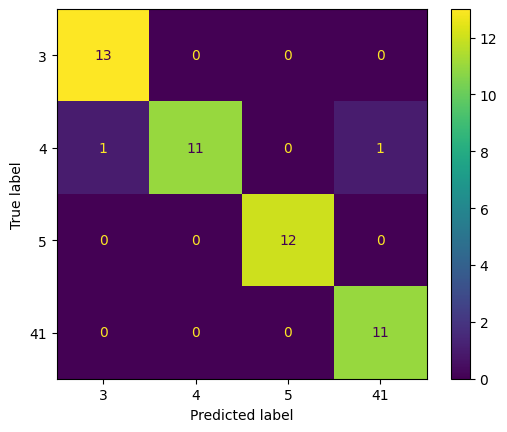

              precision    recall  f1-score   support

           3       0.93      1.00      0.96        13
           4       1.00      0.85      0.92        13
           5       1.00      1.00      1.00        12
          41       0.92      1.00      0.96        11

    accuracy                           0.96        49
   macro avg       0.96      0.96      0.96        49
weighted avg       0.96      0.96      0.96        49



In [54]:
cf_matrix = confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = [3,4,5] + [independent_class])
cm_display.plot()
plt.show()

relatorio = classification_report(y_test, y_pred, target_names = ['3','4','5'] + [str(independent_class)])
print(relatorio)